In [8]:
using JSON, PiecewiseDeterministicMarkovProcesses, LinearAlgebra, Random, DifferentialEquations
const PDMP = PiecewiseDeterministicMarkovProcesses

PiecewiseDeterministicMarkovProcesses

In [53]:
const p0  = convert(Dict{AbstractString,Float64}, JSON.parsefile("../examples/ml.json")["type II"])
const p1  = ( JSON.parsefile("../examples/ml.json"))
include("morris_lecar_variables.jl")
const p_ml = ml(p0);

In [54]:
function F_ml!(xcdot, xc, xd, parms, t::Float64)
	# vector field used for the continuous variable
	#compute the current, v = xc[1]
	xcdot[1] = xd[2] / p_ml.N * (p_ml.g_Na * (p_ml.v_Na - xc[1])) + xd[4] / p_ml.M * (p_ml.g_K  * (p_ml.v_K  - xc[1]))  + (p_ml.g_L  * (p_ml.v_L  - xc[1])) + p_ml.I_app
	nothing
end

function R_ml!(rate, xc, xd, parms, t, issum::Bool)
    rate[1] = p_ml.beta_na * exp(4.0 * p_ml.gamma_na * xc[1] + 4.0 * p_ml.k_na) * xd[1]
	rate[2] = p_ml.beta_na * xd[2]
	rate[3] = p_ml.beta_k * exp(p_ml.gamma_k * xc[1] + p_ml.k_k) * xd[3]
	rate[4] = p_ml.beta_k * exp(-p_ml.gamma_k * xc[1]  -p_ml.k_k) * xd[4]
	if issum == false
		return 0.
	else
		return sum(rate)
	end
end

R_ml! (generic function with 1 method)

In [55]:
xc0 = vec([p1["v(0)"]])
xd0 = vec([Int(p0["N"]),	#Na closed
	0,			   			#Na opened
	Int(p0["M"]),			#K closed
	0])						#K opened

nu_ml = [[-1 1 0 0];[1 -1 0 1];[0 0 -1 1];[0 0 1 -1]]
parms = vec([0.])

tf = p1["t_end"]
tf = 1000.

1000.0

In [67]:
Random.seed!(123)
pb = PDMP.PDMPProblem(F_ml!, R_ml!, nu_ml, xc0, xd0, parms, (0.0, tf))
res = @time PDMP.solve(pb, CHV(Tsit5()), save_positions = (false, true));


  0.003435 seconds (4.32 k allocations: 519.938 KiB)


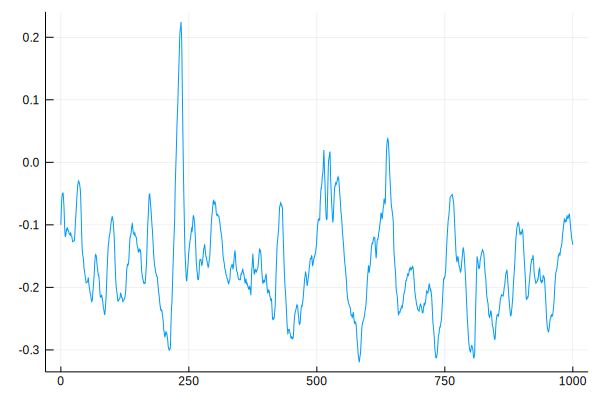

In [68]:
using Plots
plot(res.time, res.xc[1,:], label = "")

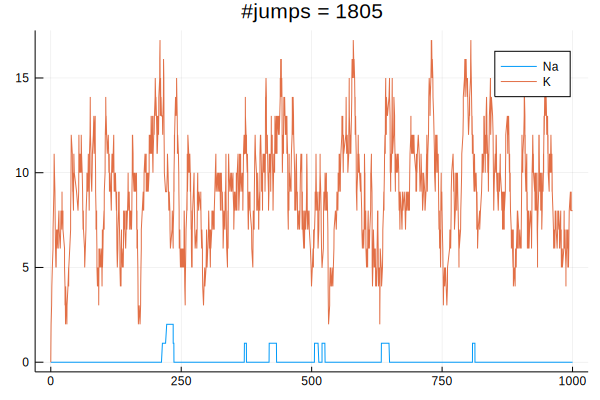

In [69]:
plot(res.time,res.xd[2, :],label = "Na", title="#jumps = $(res.njumps)")
plot!(res.time,res.xd[4, :],label = "K")